# Bayesian Optimization with Random Forests (SMAC)

## Optimizing a CNN with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset and the open source Python package Scikit-Optimize

We will use Random Forests as the surrogate function to approximate f(x)

The MNIST dataset is used here.


In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

In [2]:
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [4]:
from skopt import forest_minimize, gbrt_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
data = pd.read_csv("../mnist.csv")

# first column is the target label
# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

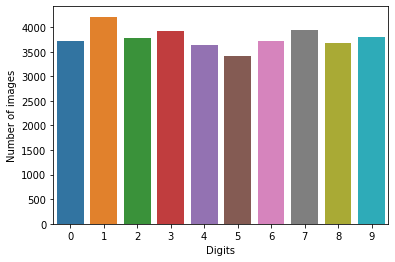

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

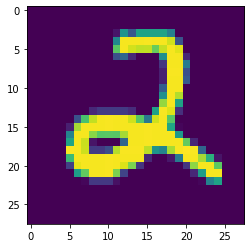

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

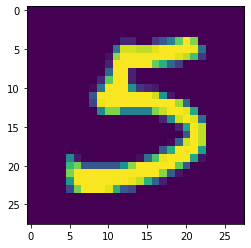

In [13]:
g = plt.imshow(X_train[10][:,:,0])

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [14]:
def create_cnn(
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # We add the different number of conv layers in the following loop:
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the Hyperparameter Space

We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of convolutional layers.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [15]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_conv_layers = Integer(low=1, high=3, name='num_conv_layers')

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [16]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_conv_layers,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

# Define the Objective Function

In [17]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [18]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_conv_layers:', num_conv_layers)
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    model = create_cnn(learning_rate=learning_rate,
                       num_conv_layers=num_conv_layers,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer this reduces the learning rate if learning does not improve for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    
    # Remember that Scikit-optimize always minimizes the objective , so we need to negate the accuracy (because we want the maximum accuracy)
    return -accuracy

## Test run

In [19]:
# Ppassing some default hyper-parameters.

default_parameters = [1e-5, 1, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_conv_layers: 1
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 32s 118ms/step - loss: 2.2763 - accuracy: 0.1598 - val_loss: 2.1896 - val_accuracy: 0.4005
Epoch 2/3
266/266 [==============================] - 30s 113ms/step - loss: 2.1463 - accuracy: 0.4596 - val_loss: 1.9901 - val_accuracy: 0.5704
Epoch 3/3
266/266 [==============================] - 29s 108ms/step - loss: 1.9163 - accuracy: 0.6062 - val_loss: 1.6954 - val_accuracy: 0.6399

Accuracy: 63.99%



-0.6399471163749695

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optimization with Random Forests

- [forest_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.forest_minimize.html#skopt.forest_minimize)
- [gbrt_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gbrt_minimize.html#skopt.gbrt_minimize)

In [20]:
# we approximate f(x) using Random Forests, we could also approximate it with gradient boosting machines using gbrt_minimize instead.

fm_ = forest_minimize(
    objective,  # the objective function to minimize
    param_grid,  # the hyperparameter space
    x0=default_parameters,  # the initial parameters to test
    acq_func='EI',  # the acquisition function
    n_calls=30,  # the number of subsequent evaluations of f(x)
    random_state=0,
)

learning rate: 1.0e-05
num_conv_layers: 1
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 33s 120ms/step - loss: 2.2871 - accuracy: 0.1525 - val_loss: 2.2050 - val_accuracy: 0.3317
Epoch 2/3
266/266 [==============================] - 33s 124ms/step - loss: 2.1590 - accuracy: 0.4053 - val_loss: 2.0152 - val_accuracy: 0.5040
Epoch 3/3
266/266 [==============================] - 30s 111ms/step - loss: 1.9453 - accuracy: 0.5436 - val_loss: 1.7307 - val_accuracy: 0.5955

Accuracy: 59.55%

learning rate: 2.4e-04
num_conv_layers: 1
num_dense_layers: 4
num_dense_nodes: 256
activation: sigmoid

Epoch 1/3
266/266 [==============================] - 34s 126ms/step - loss: 2.3137 - accuracy: 0.1062 - val_loss: 2.3029 - val_accuracy: 0.1146
Epoch 2/3
266/266 [==============================] - 34s 127ms/step - loss: 2.2443 - accuracy: 0.1579 - val_loss: 1.1837 - val_accuracy: 0.6690
Epoch 3/3
266/266 [==============================] - 33s 

266/266 [==============================] - 168s 632ms/step - loss: 0.0812 - accuracy: 0.9737 - val_loss: 0.0761 - val_accuracy: 0.9765
Epoch 3/3
266/266 [==============================] - 168s 630ms/step - loss: 0.0452 - accuracy: 0.9849 - val_loss: 0.0592 - val_accuracy: 0.9823

Accuracy: 98.23%

learning rate: 1.0e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 511
activation: relu

Epoch 1/3
266/266 [==============================] - 181s 677ms/step - loss: 0.6268 - accuracy: 0.7904 - val_loss: 0.0814 - val_accuracy: 0.9754
Epoch 2/3
266/266 [==============================] - 178s 669ms/step - loss: 0.0735 - accuracy: 0.9768 - val_loss: 0.0677 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 164s 615ms/step - loss: 0.0398 - accuracy: 0.9880 - val_loss: 0.0653 - val_accuracy: 0.9836

Accuracy: 98.36%

learning rate: 1.1e-03
num_conv_layers: 3
num_dense_layers: 3
num_dense_nodes: 497
activation: relu

Epoch 1/3
266/266 [==========================

266/266 [==============================] - 174s 651ms/step - loss: 1.4209 - accuracy: 0.4637 - val_loss: 0.1008 - val_accuracy: 0.9725
Epoch 2/3
266/266 [==============================] - 188s 706ms/step - loss: 0.0891 - accuracy: 0.9735 - val_loss: 0.0940 - val_accuracy: 0.9720
Epoch 3/3
266/266 [==============================] - 185s 695ms/step - loss: 0.0653 - accuracy: 0.9798 - val_loss: 0.0644 - val_accuracy: 0.9817

Accuracy: 98.17%



# Analyze results

In [21]:
# function value at the minimum. Note that it is the negative of the accuracy

"Best score=%.4f" % fm_.fun

'Best score=-0.9878'

In [22]:
fm_.x

[0.00120893243560701, 3, 3, 454, 'relu']

In [23]:
fm_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='identity'),
       Integer(low=1, high=3, prior='uniform', transform='identity'),
       Integer(low=1, high=5, prior='uniform', transform='identity'),
       Integer(low=5, high=512, prior='uniform', transform='identity'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [24]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_conv_laayers=%d
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" %(
    fm_.x[0], 
    fm_.x[1],
    fm_.x[2],
    fm_.x[3],
    fm_.x[4],
))

Best parameters:
- learning rate=0.001209
- num_conv_laayers=3
- num_dense_layers=3
- num_nodes=454
- activation = relu


## Convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

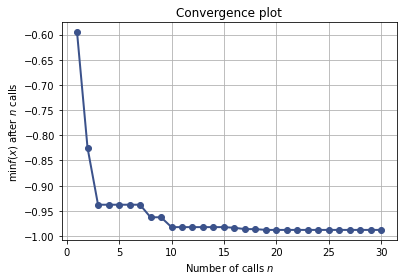

In [25]:
plot_convergence(fm_)

## Partially dependency plots

In [47]:
dim_names = ['learning_rate', 'num_conv_layers', 'num_dense_layers', 'num_dense_nodes', 'activation']

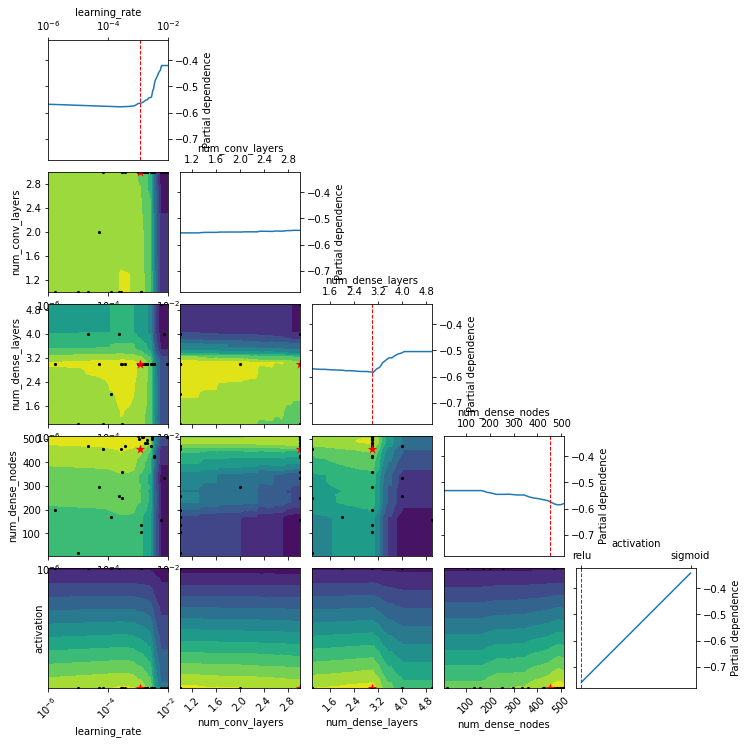

In [48]:
plot_objective(result=fm_, plot_dims=dim_names)
plt.show()

## Evaluation order

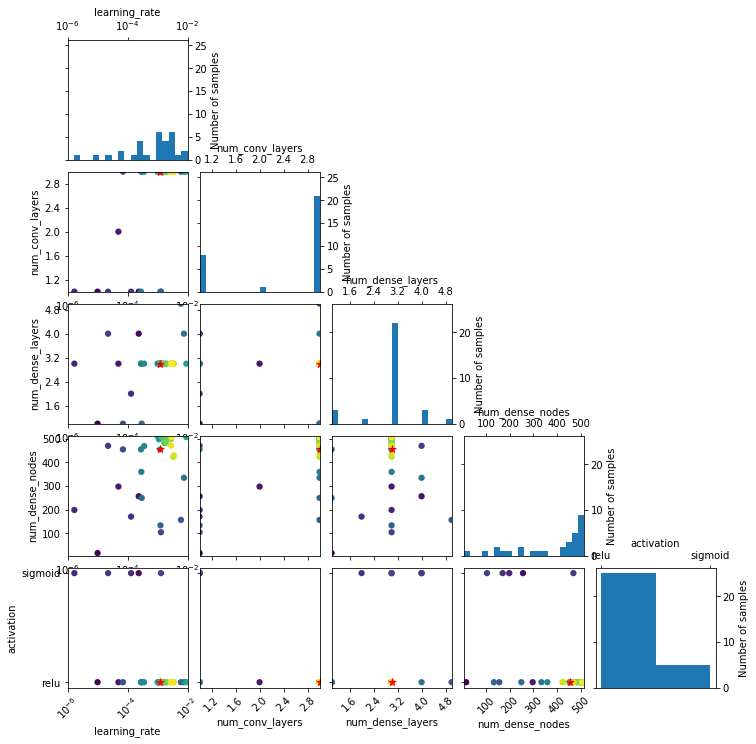

In [49]:
plot_evaluations(result=fm_, plot_dims=dim_names)
plt.show()

# Evaluate the model

In [29]:
# load best model
model = load_model(path_best_model)

In [30]:
# make predictions in test set
result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 5s 34ms/step - loss: 0.0429 - accuracy: 0.9852


In [31]:
# print evaluation metrics
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.042860597372055054
accuracy 0.9852380752563477


## Confusion matrix

In [32]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[414,   0,   0,   0,   0,   0,   3,   0,   5,   0],
       [  0, 468,   2,   0,   0,   0,   1,   1,   1,   0],
       [  1,   0, 406,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   2, 417,   0,   1,   0,   4,   2,   0],
       [  0,   2,   0,   0, 420,   0,   4,   1,   0,   2],
       [  0,   0,   0,   2,   0, 376,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 411,   0,   1,   0],
       [  0,   0,   2,   0,   0,   1,   0, 463,   0,   3],
       [  0,   2,   2,   0,   0,   0,   5,   1, 373,   1],
       [  1,   0,   0,   0,   1,   0,   1,   1,   0, 390]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

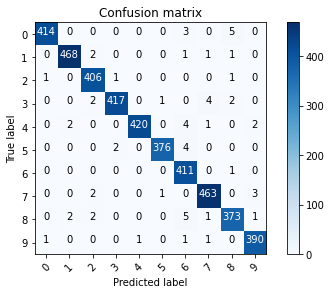

In [33]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.

# Exploring the Scikit-Optimize minimizer

In [37]:
fm_

          fun: -0.9878306984901428
    func_vals: array([-0.59550267, -0.82486773, -0.93783069, -0.10449736, -0.69021165,
       -0.08677249, -0.09603175, -0.9626984 , -0.11455026, -0.98227513,
       -0.97777778, -0.11455026, -0.97751325, -0.97989416, -0.98227513,
       -0.98359787, -0.98624337, -0.11455026, -0.9878307 , -0.98650795,
       -0.98571426, -0.98624337, -0.98518521, -0.98306876, -0.98042327,
       -0.98359787, -0.97539681, -0.11455026, -0.97936505, -0.98174602])
       models: [ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=209652396), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_stat

In [40]:
# the accuracy

fm_.func_vals

array([-0.59550267, -0.82486773, -0.93783069, -0.10449736, -0.69021165,
       -0.08677249, -0.09603175, -0.9626984 , -0.11455026, -0.98227513,
       -0.97777778, -0.11455026, -0.97751325, -0.97989416, -0.98227513,
       -0.98359787, -0.98624337, -0.11455026, -0.9878307 , -0.98650795,
       -0.98571426, -0.98624337, -0.98518521, -0.98306876, -0.98042327,
       -0.98359787, -0.97539681, -0.11455026, -0.97936505, -0.98174602])

In [52]:
# the hyperparameter combinations

fm_.x_iters

[[1e-05, 1, 1, 16, 'relu'],
 [0.00023516813385771865, 1, 4, 256, 'sigmoid'],
 [4.950159553733197e-05, 2, 3, 297, 'relu'],
 [1.6859780231705853e-06, 1, 3, 198, 'sigmoid'],
 [0.00013049073550362405, 1, 2, 170, 'sigmoid'],
 [2.2365810539197545e-05, 1, 4, 469, 'sigmoid'],
 [0.0012960656597279748, 1, 3, 104, 'sigmoid'],
 [7.01321977994579e-05, 3, 1, 454, 'relu'],
 [0.006007249475906207, 3, 5, 156, 'relu'],
 [0.0012500712230836273, 1, 3, 133, 'relu'],
 [0.0002954894558726686, 3, 1, 249, 'relu'],
 [0.007572447499093503, 3, 4, 334, 'relu'],
 [0.00027984760674257914, 1, 3, 454, 'relu'],
 [0.00028674737440100343, 3, 3, 359, 'relu'],
 [0.0003563897482846822, 3, 3, 468, 'relu'],
 [0.0010009522445704965, 3, 3, 511, 'relu'],
 [0.0011099395238989916, 3, 3, 497, 'relu'],
 [0.009075525199870838, 3, 3, 506, 'relu'],
 [0.00120893243560701, 3, 3, 454, 'relu'],
 [0.0013677319498488388, 3, 3, 506, 'relu'],
 [0.0016929517509193962, 3, 3, 481, 'relu'],
 [0.001478140251990033, 3, 3, 506, 'relu'],
 [0.001949833

In [50]:
# all together in one dataframe, so we can investigate further

tmp = pd.concat([
    pd.DataFrame(fm_.x_iters),
    pd.Series(fm_.func_vals),
], axis=1)

tmp.columns = dim_names + ['accuracy']
tmp.head()

,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,activation,accuracy
0,0.000010,1,1,16,relu,-0.595503
1,0.000235,1,4,256,sigmoid,-0.824868
2,0.000050,2,3,297,relu,-0.937831
3,0.000002,1,3,198,sigmoid,-0.104497
4,0.000130,1,2,170,sigmoid,-0.690212


In [51]:
tmp.sort_values(by='accuracy', ascending=True, inplace=True)
tmp.head(10)

,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,activation,accuracy
18,0.001209,3,3,454,relu,-0.987831
19,0.001368,3,3,506,relu,-0.986508
21,0.001478,3,3,506,relu,-0.986243
16,0.001110,3,3,497,relu,-0.986243
20,0.001693,3,3,481,relu,-0.985714
22,0.001950,3,3,494,relu,-0.985185
25,0.002852,3,3,506,relu,-0.983598
15,0.001001,3,3,511,relu,-0.983598
23,0.001943,3,3,482,relu,-0.983069
14,0.000356,3,3,468,relu,-0.982275
